In [29]:
import numpy as np
import pandas as pd
import seaborn
import matplotlib.pyplot as plt
import random

In [30]:
with open('data/X_train.npy', 'rb') as f:
    X_train = np.load(f)

In [31]:
path_y_train = 'data/y_train.csv'

y_train = pd.read_csv(path_y_train, index_col=0)

In [47]:
import torch


class SimpleNet(torch.nn.Module):
    def __init__(self, ):
        super(SimpleNet, self).__init__()
        
        self.fc1 = torch.nn.Linear(118, 118)
        self.activ1 = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(118, 56)
        self.activ2 = torch.nn.ReLU()
        self.fc3 = torch.nn.Linear(56, 24)
        self.activ3 = torch.nn.ReLU()
        self.fc4 = torch.nn.Linear(24, 2)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.activ1(x)
        x = self.fc2(x)
        x = self.activ2(x)
        x = self.fc3(x)
        x = self.activ3(x)
        x = self.fc4(x)
        return x
    
s_net = SimpleNet()

In [48]:
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset


X_train_preprocess2, X_valid_preprocess2, y_train_preprocess2, y_valid_preprocess2 =\
      train_test_split(X_train, y_train.values, test_size=0.33, random_state=100)

train_dataset = TensorDataset(torch.Tensor(X_train_preprocess2), torch.tensor(y_train_preprocess2.flatten()))
valid_dataset = TensorDataset(torch.Tensor(X_valid_preprocess2), torch.tensor(y_valid_preprocess2.flatten()))

train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=128, shuffle=True, num_workers=0, drop_last=True)
val_dataloader = torch.utils.data.DataLoader(
    valid_dataset, batch_size=128, shuffle=False, num_workers=0, drop_last=False)

In [34]:
from tqdm.notebook import tqdm


def train_model(model, loss, optimizer, scheduler, num_epochs, device):

    val_loss_history = []
    val_accuracy_history = []
    train_loss_history = []
    train_accuracy_history = []

    for epoch in (pbar := tqdm(range(num_epochs))):
        # каждая эпоха имеет этап обучения и проверки
        for phase in ['train', 'val']:
            if phase == 'train':
                dataloader = train_dataloader
                
                model.train()  # переводим модель в train mode
            else:
                dataloader = val_dataloader
                model.eval()   # переводим модель в evaluate mode

            running_loss = 0.
            running_acc = 0.

            # итерируемся по данным
            for inputs, labels in dataloader:
                inputs = inputs.to(device)  # переводим инпуты на device
                labels = labels.type(torch.LongTensor).to(device)  # переводим метки на device

                optimizer.zero_grad()   # обнуляем градиент, чтобы он не накапливался

                # forward and backward
                # set_grad_enabled не сохраняет подсчет градиентов для фазы валидации
                # set_grad_enabled выполняет то же самое, что и torch.no_grad()
                # set_grad_enabled удобнее использовать, чтобы не повторять код для forward
                with torch.set_grad_enabled(phase == 'train'):
                    preds = model(inputs)
                    # print(preds)
                    loss_value = loss(preds, labels)
                    preds_class = preds.argmax(dim=1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss_value.backward()   # считаем градиент 
                        optimizer.step()    # считаем шаг градиентного спуска
                        

                # накапливаем метрики для каждого батча
                running_loss += loss_value.item()   # item переводит на cpu
                running_acc += (preds_class == labels.data).float().mean().item()   # item переводит на cpu

            # считаем средние метрики для одной эпохи
            epoch_loss = running_loss / len(dataloader)
            epoch_acc = running_acc / len(dataloader)

            if phase == 'val':
                val_loss_history.append(epoch_loss)
                val_accuracy_history.append(epoch_acc)
            else:
                train_loss_history.append(epoch_loss)
                train_accuracy_history.append(epoch_acc)
                scheduler.step()    # говорим планировщику что прошла 1 эпоха

            pbar.set_description(f'Epoch: {epoch}')
            pbar.set_postfix_str(f'Accuracy: {epoch_acc: .3f}, \
                                 Loss: {epoch_loss: .3f}, GPU_Mem_alloc: {torch.cuda.memory_allocated()/1000000: .3f} MB, \
                                 GPU_Mem_cashed: {torch.cuda.memory_reserved()/1000000: .3f} MB')

    return val_accuracy_history, val_loss_history, train_accuracy_history, train_loss_history, model

accuracies = {}
losses = {}

In [49]:
from sklearn.utils.class_weight import compute_class_weight

device = 'cuda'
# class_weights = compute_class_weight(class_weight="balanced",
#                                      classes=np.unique(y_train),
#                                      y=y_train.values.flatten())
# class_weights = torch.tensor(class_weights,dtype=torch.float).to(device)
class_weights =  torch.tensor([0.6, 3],dtype=torch.float).to(device)

loss = torch.nn.CrossEntropyLoss(weight=class_weights, reduction='mean')
optimizer = torch.optim.Adam(s_net.parameters(), amsgrad=True, lr=1.0e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
model = s_net.to(device)


accuracies['val_s'], losses['val_s'], accuracies['train_s'], losses['train_s'], net = \
    train_model(model, loss, optimizer, scheduler, num_epochs=10, device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

In [41]:
class_weights

tensor([0.6196, 2.5903], device='cuda:0')

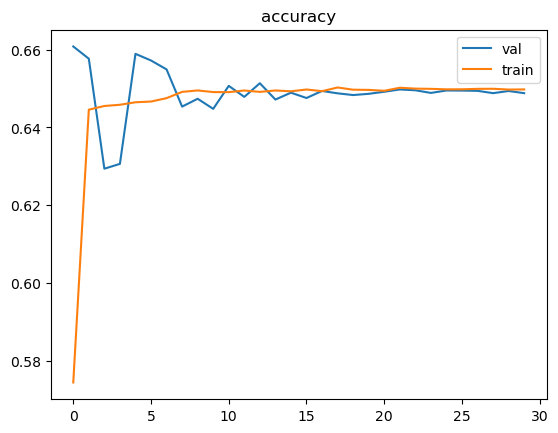

In [36]:
plt.plot(accuracies['val_s'], label='val')
plt.plot(accuracies['train_s'], label='train')
plt.title('accuracy')
plt.legend()

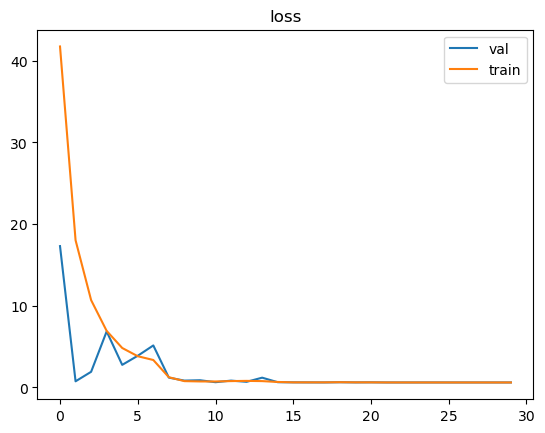

In [37]:
plt.plot(losses['val_s'], label='val')
plt.plot(losses['train_s'], label='train')
plt.title('loss')
plt.legend()

In [38]:
from sklearn.metrics import roc_auc_score


def gini(auc_score):
    return 2 * auc_score - 1

In [39]:
net.eval()

test_predictions = []
for inputs, labels in tqdm(val_dataloader):
    inputs = inputs.to(device)
    labels = labels.to(device)
    with torch.set_grad_enabled(False):
        preds = net(inputs)
    test_predictions.append(
        torch.nn.functional.softmax(preds, dim=1)[:,1].data.cpu().numpy())
    
test_predictions = np.concatenate(test_predictions)
pred = test_predictions
pred[pred >= 0.5] = 1
pred[pred < 0.5] = 0

  0%|          | 0/97 [00:00<?, ?it/s]

In [40]:
gini(roc_auc_score(y_valid_preprocess2.flatten(), pred))

0.32083138528600097

In [13]:
from sklearn.metrics import classification_report
from sklearn.metrics import (accuracy_score , f1_score , precision_score , recall_score)


print(classification_report(y_valid_preprocess2.flatten() , pred))

              precision    recall  f1-score   support

           0       0.81      1.00      0.89    319467
           1       0.07      0.00      0.00     76488

    accuracy                           0.81    395955
   macro avg       0.44      0.50      0.45    395955
weighted avg       0.66      0.81      0.72    395955



In [86]:
print("Accuracy:", accuracy_score(y_valid_preprocess2.flatten() , pred))
print("Precision:", precision_score(y_valid_preprocess2.flatten(), pred))
print("Recall:", recall_score(y_valid_preprocess2.flatten(), pred))
print("F1-score:", f1_score(y_valid_preprocess2.flatten(), pred))

Accuracy: 0.6609033854857244
Precision: 0.3186073525256648
Recall: 0.6634112540529233
F1-score: 0.43047596425072004
